# Guided Project: Predicting Bike Rentals


Many American cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day. Hadi Fanaee-T at the University of Porto compiled this data into a CSV file, which you'll be working with in this project. The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day

Here are the descriptions for the relevant columns:

- instant - A unique sequential ID number for each row
- dteday - The date of the rentals
- season - The season in which the rentals occurred
- yr - The year the rentals occurred
- mnth - The month the rentals occurred
- hr - The hour the rentals occurred
- holiday - Whether or not the day was a holiday
- weekday - The day of the week (as a number, 0 to 7)
- workingday - Whether or not the day was a working day
- weathersit - The weather (as a categorical variable)
- temp - The temperature, on a 0-1 scale
- atemp - The adjusted temperature
- hum - The humidity, on a 0-1 scale
- windspeed - The wind speed, on a 0-1 scale
- casual - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
- registered - The number of registered riders (people who had already signed up)
- cnt - The total number of bike rentals (casual + registered)

In this project, we'll try to predict the total number of bikes people rented in a given hour

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

bike_rentals=pd.read_csv(r"C:\Users\malay\Downloads\hour.csv")
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


(array([6972., 3705., 2659., 1660.,  987.,  663.,  369.,  188.,  139.,
          37.]),
 array([  1. ,  98.6, 196.2, 293.8, 391.4, 489. , 586.6, 684.2, 781.8,
        879.4, 977. ]),
 <a list of 10 Patch objects>)

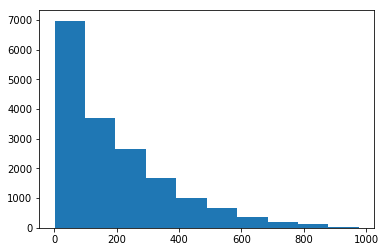

In [4]:
plt.hist(bike_rentals["cnt"])

In [6]:
bike_rentals.corr()["cnt"]

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

In [9]:
def assign_label(value):
    if value>=6 and value<12:
        return 1
    elif value>=12 and value<18:
        return 2
    elif value>=18 and value<24:
        return 3
    elif value>=0 and value<6:
        return 4
        
bike_rentals["time_label"]=bike_rentals["hr"].apply(assign_label)
bike_rentals.head(10)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16,4
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40,4
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32,4
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13,4
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1,4
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1,4
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2,1
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3,1
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8,1
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14,1


# Error metric
The mean squared error metric makes the most sense to evaluate our error. MSE works on continuous numeric data, which fits our data quite well.

In [30]:
# Creating train (80%) and test (20%) sets

train=bike_rentals.sample(frac=.8)
test=bike_rentals.loc[~bike_rentals.index.isin(train.index)]

#print(train.head())
#print(test.head())

We're ready to apply linear regression to the data. Linear regression will ~probably~ work fairly well on this data, given that many of the columns are highly correlated with cnt.

In [44]:
#Dropping some of the un-wanted columns
data_copy=bike_rentals.copy()
discardcols=["cnt","casual","registered","dteday"]
data_copy.drop(columns=discardcols, axis=1, inplace=True)
#print(data_copy.head())
predictorcols=list(data_copy.columns)
#print(predictorcols)

In [42]:
lr=LinearRegression()
lr.fit(train[predictorcols], train["cnt"])
predictions=lr.predict(test[predictorcols])
mse=mean_squared_error(test["cnt"], predictions)
print(mse)

18122.002057296166


The error is very high, which may be due to the fact that the data has a few extremely high rental counts, but otherwise mostly low counts. Larger errors are penalized more with MSE, which leads to a higher total error.

# Decision Tree
We will implement the Decision Tree algorithm now. Decision trees tend to predict outcomes much more reliably than linear regression models

In [49]:
dt=DecisionTreeRegressor(min_samples_leaf=5)
dt.fit(train[predictorcols], train["cnt"])
predictions=dt.predict(test[predictorcols])
dt_mse=mean_squared_error(test["cnt"], predictions)
print(dt_mse)

2590.650564238807


The decision tree regressor appears to have much higher accuracy than linear regression. We checked with min_sample_leaf of 2,3 etc but errors are on higher side comparatively

# Random Forest
We will now apply the random forest algorithm, which improves on the decision tree algorithm

In [59]:
rf=RandomForestRegressor(min_samples_leaf=5)
rf.fit(train[predictorcols], train["cnt"])
predictions=rf.predict(test[predictorcols])
rf_mse=mean_squared_error(test["cnt"], predictions)
print(rf_mse)

F:\Software\Ana\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


1901.792541231175


# Random forest error
By removing some of the sources of overfitting, the random forest accuracy is improved over the decision tree accuracy